In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict

from mvpa2.suite import SimpleSOMMapper
import cartopy.crs as ccrs

import xarray as xr
from xarray.core.common import _full_like as full_like

In [2]:
# projection class
class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

In [3]:
cpl_ds_list = ['$RASM-CPL_{CONTROL}$', '$RASM-CPL_{RSI}$', '$RASM-CPL_{RSH}$']
cice_ds_list = ['$RASM-SEAICE_{CONTROL}$', '$RASM-SEAICE_{RSI}$', '$RASM-SEAICE_{RSH}$']

In [4]:
ncfiles = OrderedDict()
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_ocn_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc'
ncfiles['$RASM-CPL_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.ha.197909-201412_allvars.nc'
ncfiles['$RASM-CPL_{RSI}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsi01a/cpl/monthly_mean_timeseries/R1010RBRbrsi01a.cpl.ha.197909-201412_allvars.nc'
ncfiles['$RASM-CPL_{RSH}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/cpl/monthly_mean_timeseries/R1010RBRbrsh01a.cpl.ha.197909-201412_allvars.nc'
ncfiles['$RASM-SEAICE_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/ice/monthly_mean_timeseries/R1010RBRbaaa01a.cice.hmm.197909-201412.nc'
ncfiles['$RASM-SEAICE_{RSI}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsi01a/ice/monthly_mean_timeseries/R1010RBRbrsi01a.cice.hmm.197909-201412.nc'
ncfiles['$RASM-SEAICE_{RSH}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/ice/monthly_mean_timeseries/R1010RBRbrsh01a.cice.hmm.197909-201412.nc'
# ncfiles['$RASM_{CONTROL}-OCN$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/ocn/monthly_mean_timeseries/R1010RBRbaaa01a.pop.h.197909-201412.nc'
# ncfiles['$RASM_{RSI}-OCN$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsi01a/ocn/monthly_mean_timeseries/R1010RBRbrsi01a.pop.h.197909-201412.nc'
# ncfiles['$RASM_{RSH}-OCN$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/ocn/monthly_mean_timeseries/R1010RBRbrsh01a.pop.h.197909-201412.nc'

ncdata = OrderedDict()
for k, v in ncfiles.items():
    try:
        ncdata[k] = xr.open_dataset(v, chunks={'time': 12})
    except ValueError:
        ncdata[k] = xr.open_dataset(v, decode_times=False)
        print('need to manually set the dates for %s' % k)
        
    if k.startswith('$RASM-CPL'):
        ncdata[k] = ncdata[k].rename({'a2xavg_nx': 'ni',
                                      'a2xavg_ny': 'nj',
                                      'l2xavg_nx': 'ni',
                                      'l2xavg_ny': 'nj',
                                      'x2aavg_nx': 'ni',
                                      'x2aavg_ny': 'nj',
                                      'x2lavg_nx': 'ni',
                                      'x2lavg_ny': 'nj'
                                      })
        
#         Dimensions:             (dim_0: 3, l2xavg_nx: 275, l2xavg_ny: 205, ni: 275, nj: 205, time: 424, x2lavg_nx: 275, x2lavg_ny: 205)

need to manually set the dates for rasm_domain
need to manually set the dates for rasm_ocn_masks


In [5]:
# # missing 1983-06, not sure why but we don't need it for this analysis
# fnames = ncdata['$RASM_{CONTROL}-OCN$'].attrs['history'].split()[10:-2]
# dates = []
# from datetime import datetime
# for fname in fnames:
#     year, month = map(int, fname.split('.')[-2].split('-'))
#     dates.append(datetime(year, month, 1))
# ncdata['$RASM_{CONTROL}-OCN$']['time'] = pd.DatetimeIndex(dates)


In [6]:
for k in cpl_ds_list:
    ncdata[k].coords['xc'] = ncdata['rasm_domain']['xc']
    ncdata[k].coords['yc'] = ncdata['rasm_domain']['yc']
    for v in ['mask', 'frac', 'area']:
        ncdata[k][v] = ncdata['rasm_domain'][v]
ncdata[k]


<xarray.Dataset>
Dimensions:             (ni: 275, nj: 205, time: 424)
Coordinates:
  * time                (time) datetime64[ns] 1979-09-16 1979-10-16T12:00:00 ...
  * nj                  (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * ni                  (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    yc                  (nj, ni) float64 16.53 16.78 17.02 17.27 17.51 17.76 ...
    xc                  (nj, ni) float64 189.2 189.4 189.6 189.7 189.9 190.1 ...
Data variables:
    x2aavg_Sx_t         (time, nj, ni) float64 301.0 301.0 301.0 301.0 301.0 ...
    x2aavg_Faxx_evap    (time, nj, ni) float64 -1.511e-05 -2.827e-05 ...
    a2xavg_Sa_u         (time, nj, ni) float64 -6.78 -7.21 -7.202 -7.157 ...
    a2xavg_Sa_v         (time, nj, ni) float64 -1.536 -1.205 -1.158 -1.129 ...
    a2xavg_Sa_tbot      (time, nj, ni) float64 300.6 300.6 300.6 300.6 300.6 ...
    a2xavg_Sa_pbot      (time, nj, ni) float64 1.011e+05 1.012e+05 1.012e+05 ...
    a2xavg_Sa_pslv      (

In [7]:
# ncdata['$RASM_{CONTROL}-SEAICE$'].time.values -= np.timedelta64(1, 'D')
# ncdata['$RASM_{CONTROL}-SEAICE$'] = ncdata['$RASM_{CONTROL}-SEAICE$'].resample('MS', ÷dim='time', how='first')
for k in cice_ds_list:
    ncdata[k]['time'] = pd.date_range('1979-09', '2014-12', freq='MS')
    ncdata[k] = ncdata[k].sel(time=slice('1985','2015'))


In [8]:

for k in cpl_ds_list:

    ncdata[k] = ncdata[k].sel(time=slice('1985','2015'))
    
    ncdata[k]['total_precip'] = (ncdata[k].a2xavg_Faxa_rainc +
                                 ncdata[k].a2xavg_Faxa_rainl +
                                 ncdata[k].a2xavg_Faxa_snowc +
                                 ncdata[k].a2xavg_Faxa_snowl)

    ncdata[k]['evap'] = ncdata[k].x2aavg_Faxx_evap * -1
    
    


In [9]:
# stack the ensemble members together
combined_cpl_ds = xr.concat([ncdata[k] for k in cpl_ds_list], dim=xr.DataArray(cpl_ds_list, name='member', dims=('member', )))


In [10]:
combined_cice_ds = xr.concat([ncdata[k] for k in cice_ds_list], dim=xr.DataArray(cice_ds_list, name='member', dims=('member', )))

In [11]:
def set_map_features(ax, extent=[-180, 0,  53, 90]):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree())
    if extent:
        ax.set_extent(extent)


In [12]:
def anomalies(da, by='time.month', dim='time', standardize=True):
    g = da.groupby(by)
    climatology = g.mean(dim)

    anomalies = (g - climatology)
    if standardize:
        std = g.std(dim)
        anomalies = anomalies.groupby(by) / std
    
    return anomalies

def sel_som_data(da, mask=None):
    dar = da.sel(time=da.indexes['time'].month > 9)
    if mask is not None:
        dar = dar.where(mask)
    return dar

In [13]:
precip_anoms = anomalies(combined_cpl_ds['total_precip'], standardize=False)
precip_anoms_std = anomalies(combined_cpl_ds['total_precip'], standardize=True)
evap_anoms = anomalies(combined_cpl_ds['evap'], standardize=True)
temp_anoms = anomalies(combined_cpl_ds['a2xavg_Sa_tbot'], standardize=False)
p_minus_e = (combined_cpl_ds['total_precip'] - combined_cpl_ds['evap'])
p_minus_e_anoms = anomalies(p_minus_e, standardize=False)
sea_ice_anoms = anomalies(combined_cice_ds['aice'], standardize=False)
sea_ice_anoms_std = anomalies(combined_cice_ds['aice'], standardize=True)

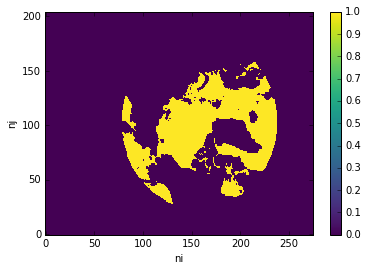

In [14]:
# If using sea ice
# mask = (ncdata['$RASM_{CONTROL}-SEAICE$']['aice'].max(dim='time') != ncdata['$RASM_{CONTROL}-SEAICE$']['aice'].min(dim='time')).where(ncdata['$RASM_{CONTROL}-SEAICE$']['aice'].min(dim='time') > 0)

# other mask
lat_thresh = 55
mask = (ncdata['rasm_domain']['mask'] == 0).where(ncdata['rasm_domain'].yc > lat_thresh) > 0
mask.plot()

In [15]:
data = sel_som_data(evap_anoms, mask=mask)
nens, ntime, ny, nx = data.shape
nspace = ny * nx

ys, xs = np.nonzero(mask.values > 0)

print(data.shape)
dr = data.values[..., ys, xs]
dr = dr.reshape(-1, dr.shape[-1])
print(dr.shape)
som_shape = (3, 4)

(3, 90, 205, 275)


/home/jhamman/anaconda/envs/mvpa2/lib/python2.7/site-packages/dask/async.py:245: RuntimeWarning: invalid value encountered in divide
  return func(*args2)


(270, 8047)


In [16]:
stacked_shape = (nens*ntime, ny, nx)
print(stacked_shape)

(270, 205, 275)


In [17]:
stacked_shape_ice = (nens*ntime, ) + ncdata['rasm_ocn_masks'].mask.shape
stacked_shape_ice

(270, 720, 1280)

In [18]:
som = SimpleSOMMapper(som_shape, 1000, learning_rate=0.001)
som

SimpleSOMMapper(kshape=(3, 4), niter=1000, learning_rate=0.001000, iradius=4.000000)

In [19]:
%time som.train(dr)

CPU times: user 5min 23s, sys: 0 ns, total: 5min 23s
Wall time: 5min 23s


In [20]:
# This gives us the location of each timestep in the SOM
som_inds = [tuple(si) for si in som.forward(dr)]

In [21]:
som_fraction_threshold = 2
som_fracs = {}
for i in set(som_inds):
    som_fracs[i] = float(som_inds.count(i)) / len(som_inds) * 100
    print(i, som_fracs[i])

((1, 2), 17.77777777777778)
((0, 1), 3.7037037037037033)
((0, 0), 4.444444444444445)
((2, 1), 7.037037037037037)
((0, 2), 4.814814814814815)
((2, 0), 10.74074074074074)
((1, 3), 5.555555555555555)
((2, 3), 8.148148148148149)
((2, 2), 8.148148148148149)
((1, 0), 11.851851851851853)
((0, 3), 11.11111111111111)
((1, 1), 6.666666666666667)


In [22]:
# k_da = xr.DataArray(som.K.reshape(som_shape + (ny, nx)), dims=('som_y', 'som_x') + precip_anoms.dims[1:])
k_da = xr.DataArray(np.full(som_shape + (ny, nx), np.nan), dims=('som_y', 'som_x') + data.dims[2:])
k_da.coords['ni'] = data.coords['ni']
k_da.coords['nj'] = data.coords['nj']
k_da.coords['xc'] = data.coords['xc']
k_da.coords['yc'] = data.coords['yc']
empty = full_like(k_da)

# k_da = xr.DataArray(np.full(som_shape + (ny, nx), np.nan), dims=('som_y', 'som_x') + sea_ice_anoms.dims[1:])

# k_da.coords['ni'] = data.coords['ni']
# k_da.coords['nj'] = data.coords['nj']
# k_da.coords['xc'] = data.coords['TLON']
# k_da.coords['yc'] = data.coords['TLAT']

# empty = xr.DataArray(np.full(som_shape + (205, 275), np.nan), dims=('som_y', 'som_x') + precip_anoms.dims[1:])
# empty.coords['xc'] = precip_anoms.coords['xc']
# empty.coords['yc'] = precip_anoms.coords['yc']

In [23]:
# unpack the SOMs
k_da.values[..., ys, xs] = som.K

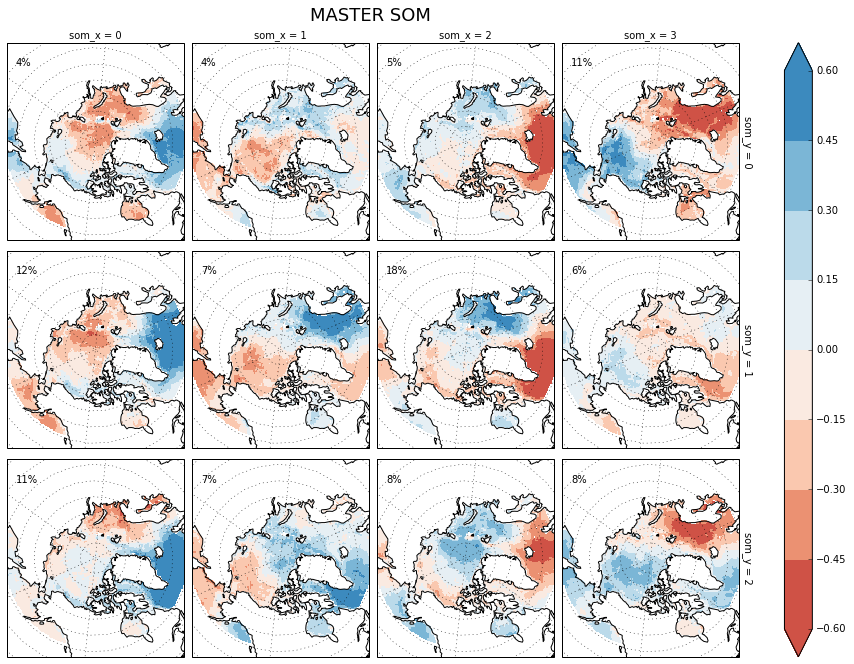

In [24]:
fg = k_da.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                           robust=True,
                          extend='both', levels=11,
                           subplot_kws=dict(projection=Rasm()),
                           transform=ccrs.PlateCarree())
for i in set(som_inds):
    fg.axes[i].text(0.05, 0.9,'{:.0f}%'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    set_map_features(fg.axes[i])
    
fg.fig.suptitle('MASTER SOM', fontsize=18, y=1.02, x=0.4)

fig.savefig('../figs/master_som.png', dpi=300)

In [25]:
def map_to_som(da, like=k_da, som_inds=som_inds, stacked_shape=stacked_shape):
    mapped_som = full_like(like, fill_value=np.nan)

    for i in set(som_inds):
        bool_mask = [i == si for si in som_inds]
        mapped_som[dict(som_y=i[0], som_x=i[1])] = da.values.reshape(stacked_shape)[np.nonzero(bool_mask)[0]].mean(axis=0)

        
    return mapped_som

In [26]:
def add_som_hit_rate_to_subplot(ax, hr):
    ax.text(0.05, 0.9,'{:.0f}%'.format(hr),
            horizontalalignment='left',
            verticalalignment='center',
            transform = ax.transAxes)
    

In [27]:
da = sel_som_data(precip_anoms)

like = k_da

mapped_som = full_like(like, fill_value=np.nan)

for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    mapped_som[dict(som_y=i[0], som_x=i[1])] = da.values.reshape(stacked_shape)[np.nonzero(bool_mask)[0]].mean(axis=0)

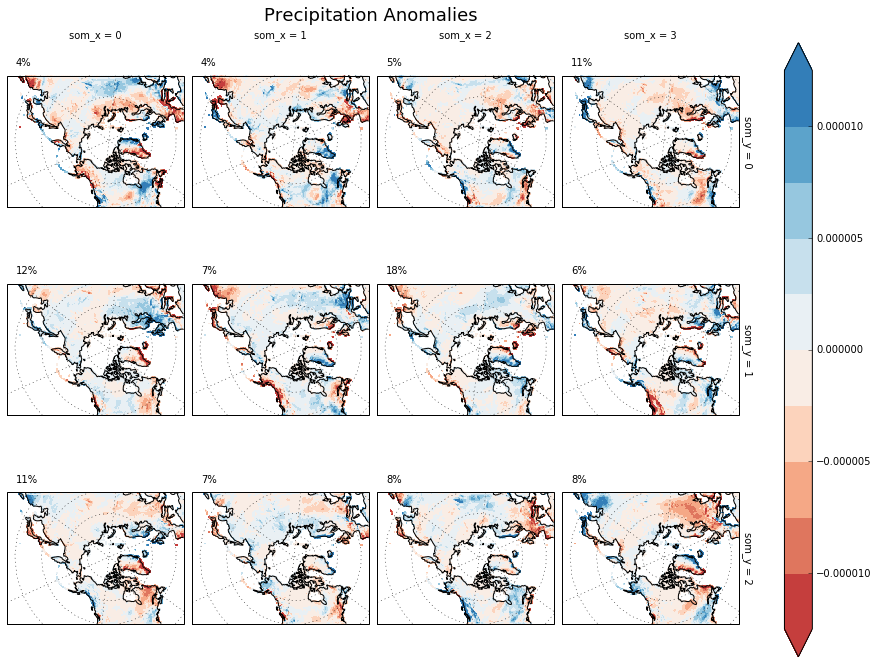

In [28]:
precip_mapped_som = map_to_som(sel_som_data(precip_anoms)).where(ncdata['rasm_domain']['mask'] > 0)



fg = precip_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Precipitation Anomalies', fontsize=18, y=1.02, x=0.4)

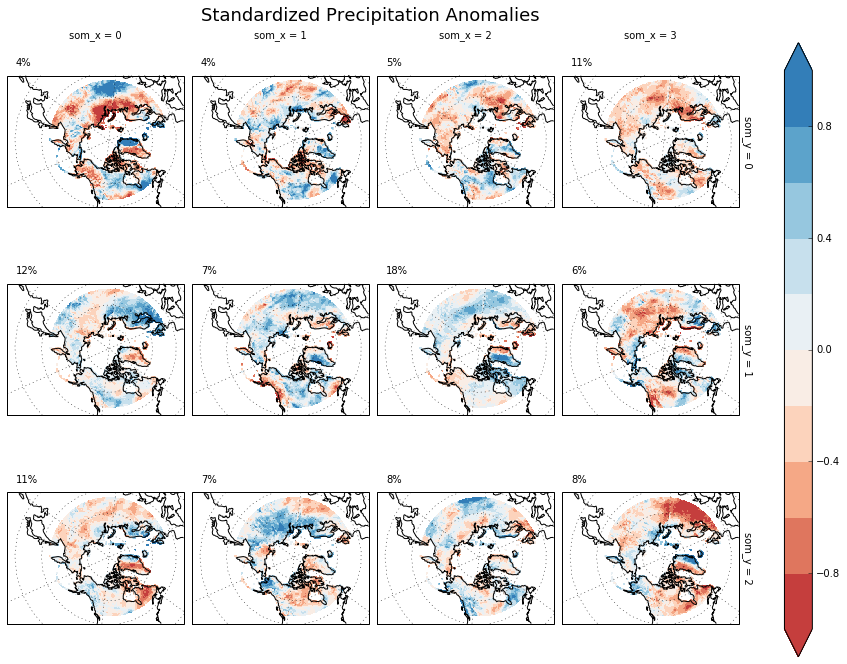

In [29]:
precip_mapped_som = map_to_som(sel_som_data(precip_anoms_std)).where((ncdata['rasm_domain']['mask'] > 0) &
                                                                     (ncdata['rasm_domain']['yc'] > 50))
    
fg = precip_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Standardized Precipitation Anomalies', fontsize=18, y=1.02, x=0.4)

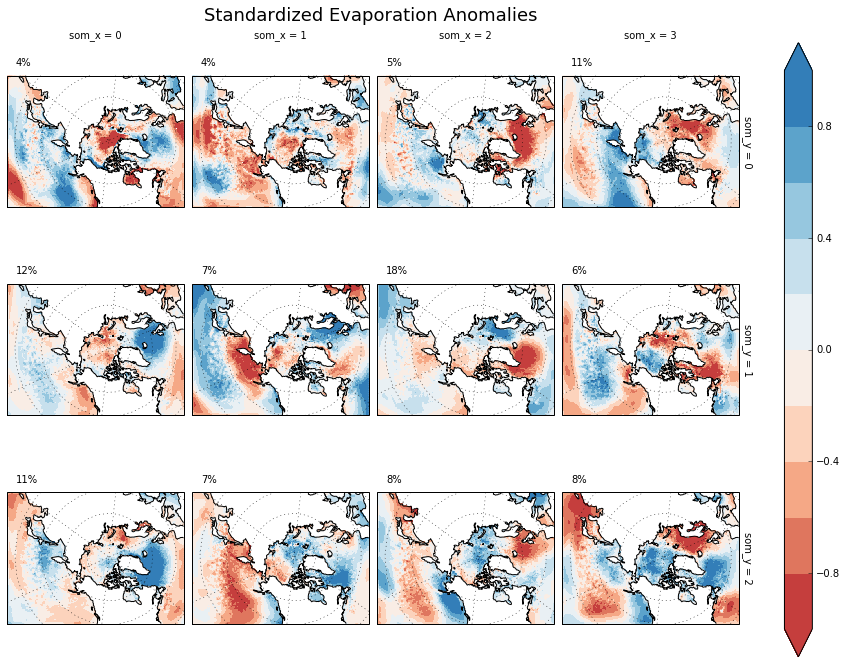

In [30]:
evap_mapped_som = map_to_som(sel_som_data(evap_anoms)).where(ncdata['rasm_domain']['mask'] == 0)
    
fg = evap_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Standardized Evaporation Anomalies', fontsize=18, y=1.02, x=0.4)

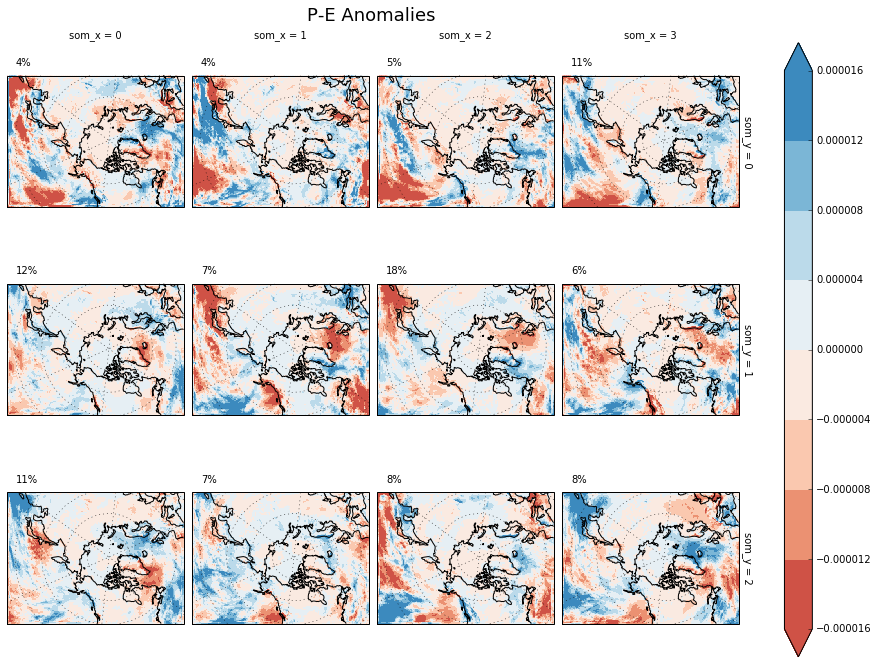

In [31]:
p_minus_e_mapped_som = map_to_som(sel_som_data(p_minus_e_anoms))
    
fg = p_minus_e_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('P-E Anomalies', fontsize=18, y=1.02, x=0.4)

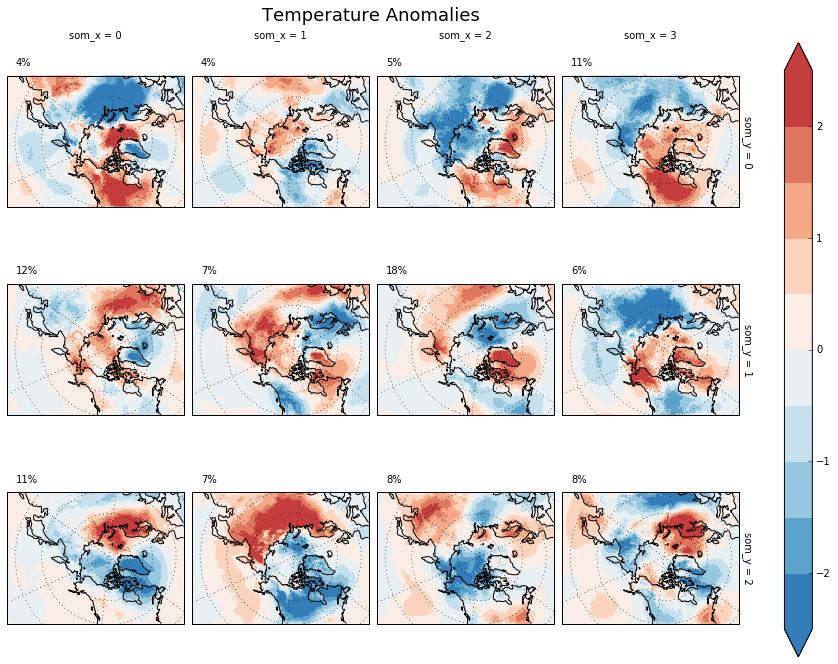

In [32]:
temp_mapped_som = map_to_som(sel_som_data(temp_anoms))
    
fg = temp_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu_r',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Temperature Anomalies', fontsize=18, y=1.02, x=0.4)

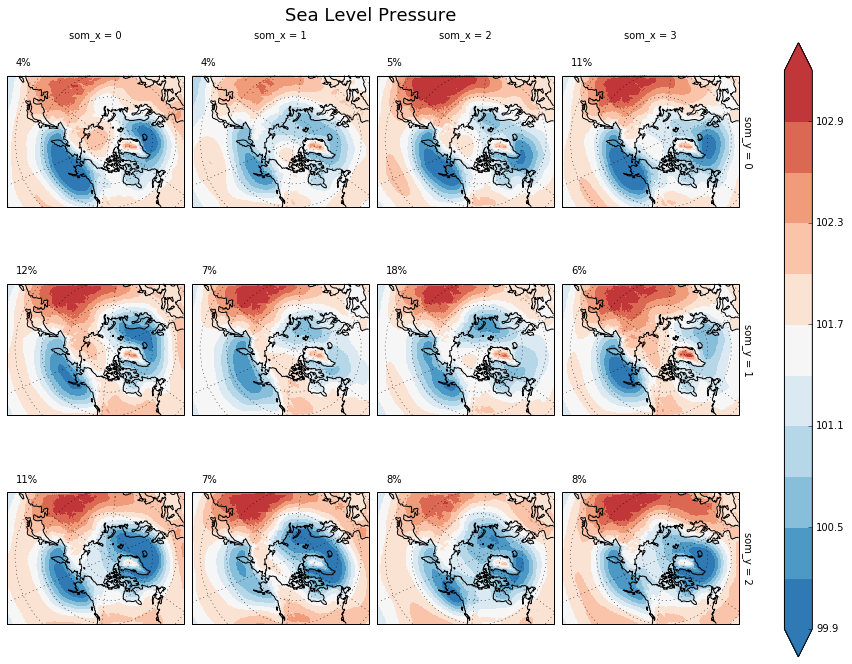

In [33]:
slp_mapped_som = map_to_som(sel_som_data(combined_cpl_ds.a2xavg_Sa_pslv / 1000))
    
fg = slp_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu_r',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Sea Level Pressure', fontsize=18, y=1.02, x=0.4)

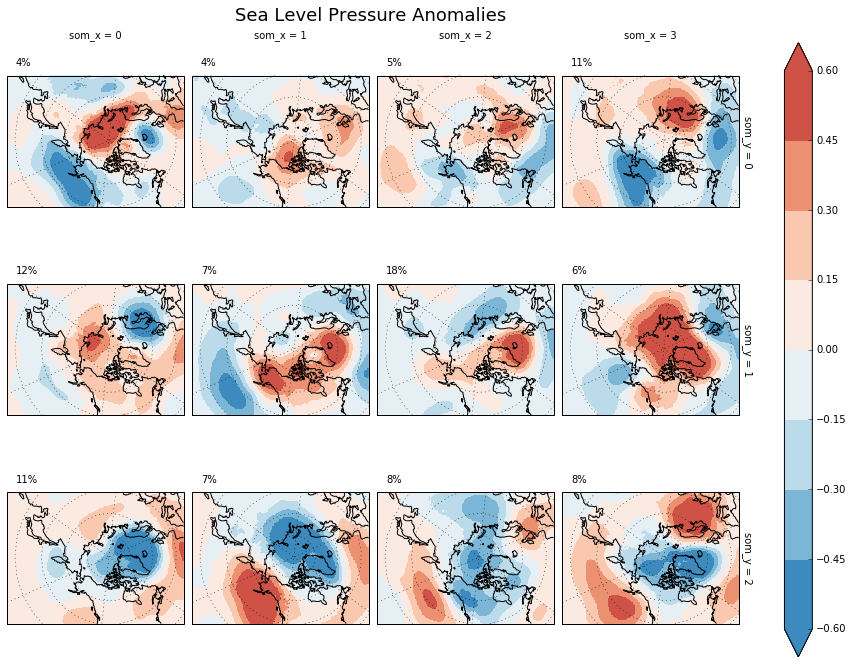

In [34]:
slp_mapped_som = map_to_som(sel_som_data(anomalies(combined_cpl_ds.a2xavg_Sa_pslv / 1000,
                                                   standardize=False)))

    
fg = slp_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu_r',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Sea Level Pressure Anomalies', fontsize=18, y=1.02, x=0.4)

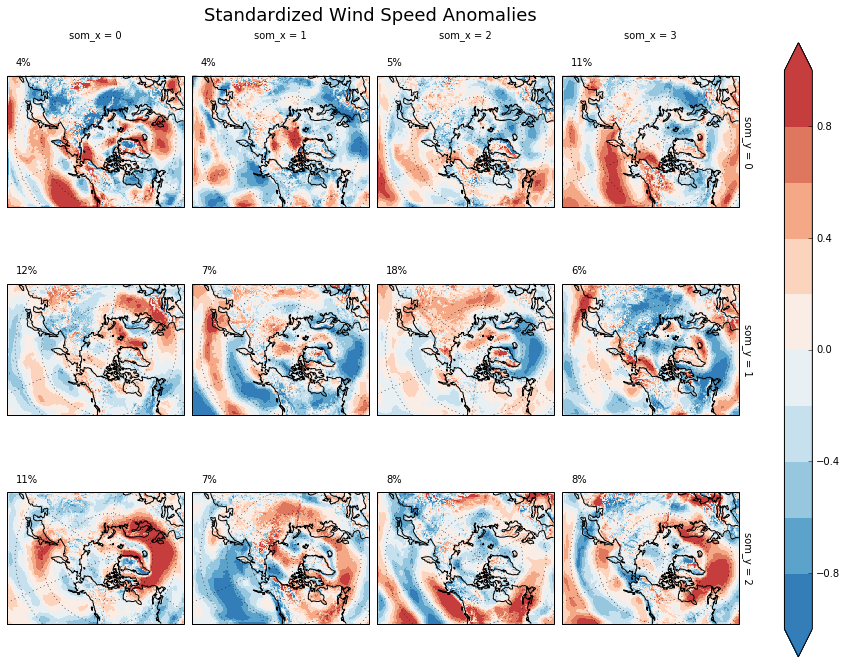

In [35]:
wind_speed = np.sqrt(combined_cpl_ds.a2xavg_Sa_u ** 2 + combined_cpl_ds.a2xavg_Sa_v ** 2)

wind_mapped_som = map_to_som(sel_som_data(anomalies(wind_speed, standardize=True)))
    
fg = wind_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu_r',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Standardized Wind Speed Anomalies', fontsize=18, y=1.02, x=0.4)

/home/jhamman/anaconda/envs/mvpa2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


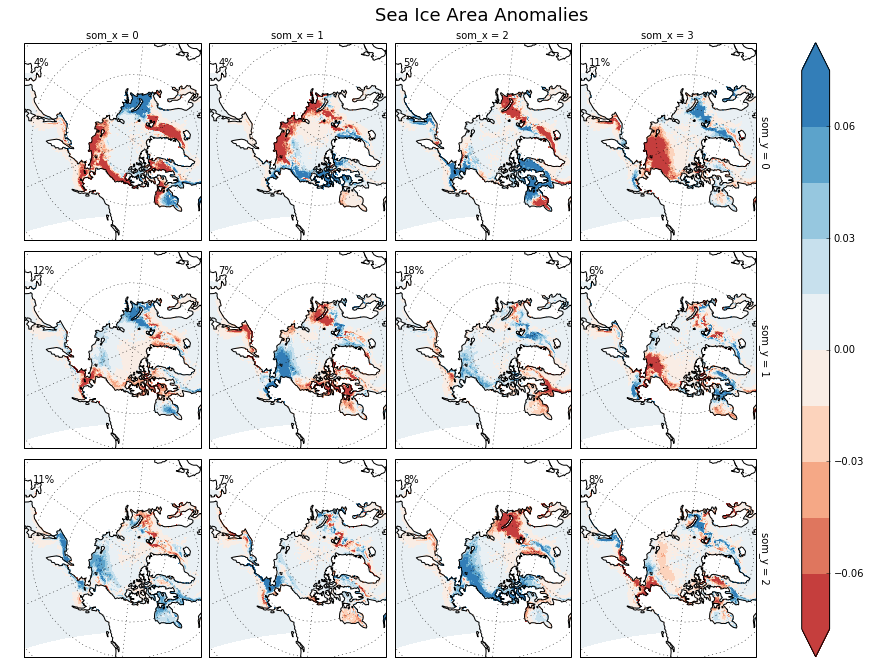

In [37]:
empty_ice = xr.DataArray(np.full(som_shape + sea_ice_anoms.shape[2:], np.nan),
                                  dims=('som_y', 'som_x') + sea_ice_anoms.dims[2:])
sea_ice_mapped_som = map_to_som(sel_som_data(sea_ice_anoms), stacked_shape=stacked_shape_ice,
                                like=empty_ice)
    
sea_ice_mapped_som.coords['xc'] = sea_ice_anoms['TLON']
sea_ice_mapped_som.coords['yc'] = sea_ice_anoms['TLAT']
sea_ice_mapped_som
fg = sea_ice_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu',
                                       robust=True, extend='both', levels=11,
                                       subplot_kws=dict(projection=Rasm()),
                                       transform=ccrs.PlateCarree())

for i in set(som_inds):
    add_som_hit_rate_to_subplot(fg.axes[i], som_fracs[i])
    set_map_features(fg.axes[i], extent=None)
    
fg.fig.suptitle('Sea Ice Area Anomalies', fontsize=18, y=1.02)


In [67]:
ice_mask = (ncdata['rasm_ocn_masks']['mask'] > 0).rename({'y': 'nj', 'x': 'ni'})

In [77]:
composite_data = {'Precipitation': 86400 * map_to_som(sel_som_data(precip_anoms)).where(ncdata['rasm_domain']['mask'] > 0),
                  'Evaporation': map_to_som(sel_som_data(evap_anoms)).where(ncdata['rasm_domain']['mask'] == 0),
                  'SLP': map_to_som(sel_som_data(combined_cpl_ds.a2xavg_Sa_pslv / 1000)),
                  'Wind Anomalies': map_to_som(sel_som_data(anomalies(wind_speed, standardize=False))),
#                   'SST Anomalies': map_to_som(sel_som_data(anomalies(sst.rename({'TLONG': 'xc', 'TLAT': 'yc'}), standardize=False)), like=sst_mapped_som),
                  'Sea Ice Anomalies': map_to_som(sel_som_data(sea_ice_anoms), stacked_shape=stacked_shape_ice, like=sea_ice_mapped_som).where(ice_mask == 1),
                 }

for v in ['Sea Ice Anomalies']:
    composite_data[v]['xc'].values = ncdata['rasm_ocn_masks']['ULON'].values
    composite_data[v]['yc'].values = ncdata['rasm_ocn_masks']['ULAT'].values

In [88]:
composite_plot_args = {'Precipitation': dict(vmin=-0.5, vmax=0.5, cmap='RdBu', extend='both', levels=12, label=''),
                       'Evaporation': dict(vmin=-0.7, vmax=0.7, cmap='RdBu', extend='both', levels=12),
                       'SLP': dict(vmin=99.325, vmax=103.325, cmap='RdBu_r', extend='both', levels=12),
                       'Wind Anomalies': dict(vmin=-1, vmax=1, cmap='RdBu_r', extend='both', levels=12),
                       'SST Anomalies': dict(vmin=-0.7, vmax=0.7, cmap='RdBu_r', extend='both', levels=12),
                       'Sea Ice Anomalies': dict(vmin=-0.1, vmax=0.1, cmap='RdBu', extend='both', levels=12),
                 }

labels = {'Precipitation': 'Precipitation Anom.\n(std. anoms.)',
          'Evaporation': 'Evaporation Anom.\n(std. anoms.)',
          'SLP': 'SLP\n(kPa)',
          'Wind Anomalies': 'Wind Anom.\n(m/s)',
          'SST Anomalies': 'SST Anoms.\n(C)',
          'Sea Ice Anomalies': 'Sea Ice Concentration\n(fraction)'}

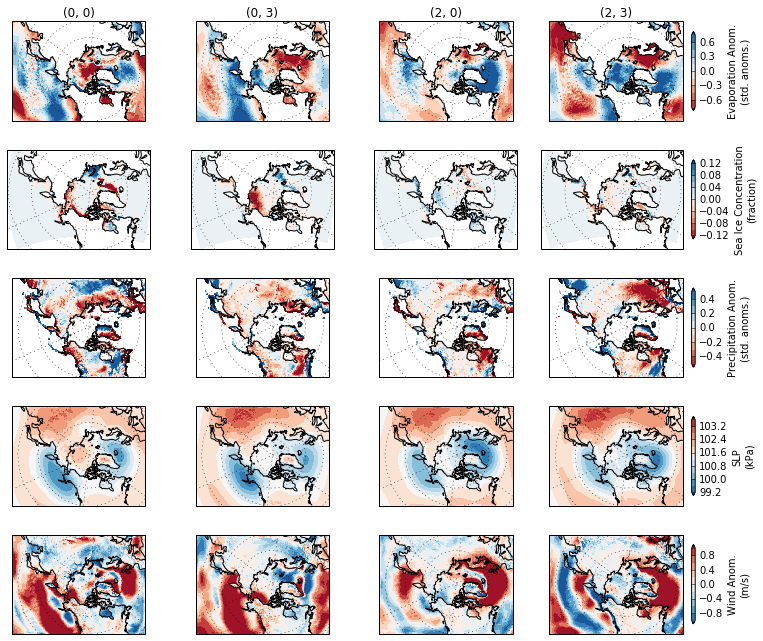

In [94]:
# composite som figure
composite_som_inds = [(0, 0), (0, 3), (2, 0), (2, 3)]
variables = ['Evaporation', 'Sea Ice Anomalies', 'Precipitation', 'SLP', 'Wind Anomalies']

fig, axes = plt.subplots(len(variables), len(composite_som_inds), figsize=(11, 9),
                         subplot_kw=dict(projection=Rasm()))

for i, var in enumerate(variables):
    for j, ind in enumerate(composite_som_inds):
        ax = axes[i, j]
        da = composite_data[var][dict(som_y=ind[0],
                                      som_x=ind[1])]
        
        if j == len(composite_som_inds) - 1:
            composite_plot_args[var]['add_colorbar'] = True
            composite_plot_args[var]['cbar_kwargs'] = dict(shrink=0.8, label=labels[var])
        else:
            composite_plot_args[var]['add_colorbar'] = False
            composite_plot_args[var].pop('cbar_kwargs', None)

        
        m = da.plot.pcolormesh('xc', 'yc',
                               ax=ax, transform=ccrs.PlateCarree(),
                               **composite_plot_args[var])
        set_map_features(ax, extent=None)
        
        if i == 0:
            ax.set_title(ind)
        else:
            ax.set_title('')
        
fig.tight_layout()

fig.savefig('../figs/composite_som.png', dpi=300)

In [90]:
grid_inds = np.array(som_inds, dtype=np.dtype('int,int')).reshape((nens, ntime))

months = [0, 1, 2] * 30
grid_inds.shape

(3, 90)

In [91]:
hits = {}

nmonths = 3

for i in set(som_inds):
    hits[i] = np.zeros((nens, nmonths))

In [92]:
for (e, mi), i in np.ndenumerate(grid_inds):
    hits[tuple(i)][months[mi], e] += 1

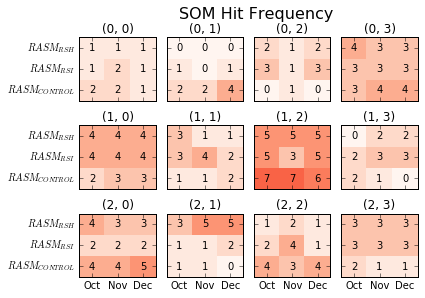

In [93]:
fig, axes = plt.subplots(*som_shape, sharex=True, sharey=True)
for i in set(som_inds):
    axes[i].pcolormesh((hits[i] / len(som_inds)), cmap='Reds', vmin=0, vmax=0.05)
    axes[i].set_yticks([0.5, 1.5, 2.5])
    axes[i].set_yticklabels(['$RASM_{CONTROL}$', '$RASM_{RSI}$', '$RASM_{RSH}$'])
    axes[i].set_xticks([0.5, 1.5, 2.5])
    axes[i].set_xticklabels(['Oct', 'Nov', 'Dec'])
    axes[i].set_title(i)

    for (y, x), val in np.ndenumerate(hits[i]):
        axes[i].text(x+0.5, y+0.5,'{:.0f}'.format(val),
                    horizontalalignment='center',
                    verticalalignment='center')

fig.tight_layout()
plt.suptitle('SOM Hit Frequency', x=0.6, y=1.02, fontsize=16)
fig.savefig('../figs/som_hit_freq.png', dpi=300)